# Neural-Backed Decision Trees (NBDT) Demonstration with VGG16 and CIFAR10

## 1. Load libraries

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

from nbdt.model import SoftNBDT
from nbdt.loss import SoftTreeSupLoss
from nbdt.hierarchy import generate_hierarchy
from nbdt.tree import Tree
from PIL import Image
from utils import train, test, load_vgg16, load_data, plot_decision_tree

torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

stty: 'standard input': Inappropriate ioctl for device


not enough values to unpack (expected 2, got 0)


## 2. Load data and model

In [2]:
classes = (
    'airplane', 'car', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
)

trainloader, testloader = load_data()

Files already downloaded and verified


In [3]:
model = load_vgg16(num_classes=10).to(device)
model

Using cache found in /home/vichshir/.cache/torch/hub/pytorch_vision_v0.10.0
/home/vichshir/miniconda3/envs/nbdt/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vichshir/miniconda3/envs/nbdt/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 3. Pre-train final linear weights

In [4]:
# only the final linear's weights will be updated
optimizer = torch.optim.SGD(model.classifier[-1].parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
# try changing the number of epochs to generate different hierarchies
train(model, trainloader, optimizer, nn.CrossEntropyLoss(), epochs=3, device=device)

100%|█████████████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.79it/s]


## 4. Generate Induced Hierarchy

In [5]:
# generate hierarchy from pretrained model
generate_hierarchy(dataset='CIFAR10', arch='vgg16', model=model, method='induced')

# generate tree visualizer in HTML
tree = Tree(dataset='CIFAR10', path_graph=None, path_wnids=None, classes=None, hierarchy='induced-vgg16')
tree.visualize('./out/CIFAR10-induced-VGG16-tree.html', dataset='CIFAR10')

[matched] 	 Nodes: 19 	 Depth: 5 	 Max Children: 9
[pruned] 	 Nodes: 19 	 Depth: 5 	 Max Children: 9
==> Wrote tree to ./nbdt/hierarchies/CIFAR10/graph-induced-vgg16.json 


## 5. Finetune with Tree Supervision Loss

In [6]:
# update all model's weights
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
criterion = SoftTreeSupLoss(dataset='CIFAR10', hierarchy='induced-vgg16', criterion=criterion)
train(model, trainloader, optimizer, criterion, epochs=2, device=device)

100%|█████████████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.70it/s]


## 6. Evaluate model

In [7]:
model_nbdt = SoftNBDT(model=model, dataset='CIFAR10', hierarchy='induced-vgg16')
model_nbdt.eval()

# evaluate on test set
test_acc = test(model_nbdt, testloader)
print('Test accuracy:', test_acc)

100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 37.80it/s]

Test accuracy: 0.8346


In [8]:
# save checkpoint
torch.save(
    {'state_dict': model_nbdt.state_dict()}, 
    './SoftNBDT_model.pt'
)

In [9]:
# [optional] restore model weights
state_dict = torch.load('./SoftNBDT_model.pt')
model_weights = state_dict['state_dict']

model_nbdt = SoftNBDT(model=model, dataset='CIFAR10', hierarchy='induced-vgg16')
model_nbdt.load_state_dict(model_weights)
model_nbdt.eval()

SoftNBDT(
  (rules): SoftEmbeddedDecisionRules()
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

## 7. Run inference using Embedded Decision Rules

Sample label: cat


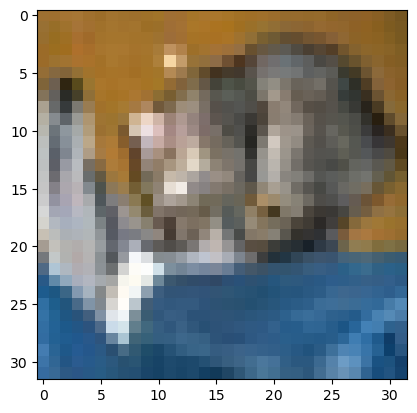

In [10]:
# get individual sample from test set
b = next(iter(testloader))
X = b[0][0].unsqueeze(0).to(device)
y = b[1][0]

print('Sample label:', classes[y])

# visualize sample
plt.imshow(X.cpu().squeeze(0).movedim(0,-1))
plt.show()

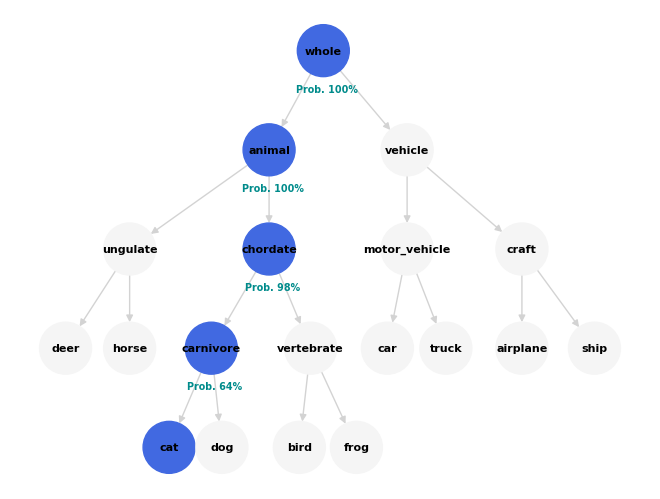

In [11]:
# visualize decisions
plot_decision_tree(model_nbdt.forward_with_decisions(X)[1][0], model_nbdt)

## 8. Predict with an external image

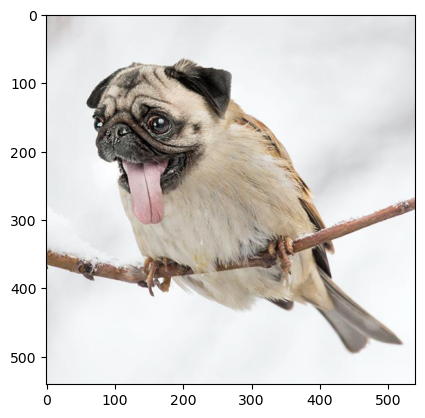

In [12]:
img = Image.open('./images/birddog.png').convert('RGB')
img = np.asarray(img)
plt.imshow(img)
plt.show()

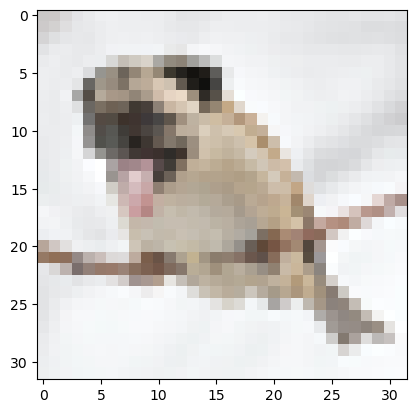

In [13]:
# maintain CIFAR10 size (32x32)
img = Image.open('./images/birddog.png').convert('RGB').resize((32, 32))
img = np.asarray(img)
plt.imshow(img)
plt.show()

In [20]:
# show prediction
pred_label = classes[torch.argmax(model_nbdt(img_torch), dim=1)]
print('Predicted label:', pred_label)

Predicted label: bird


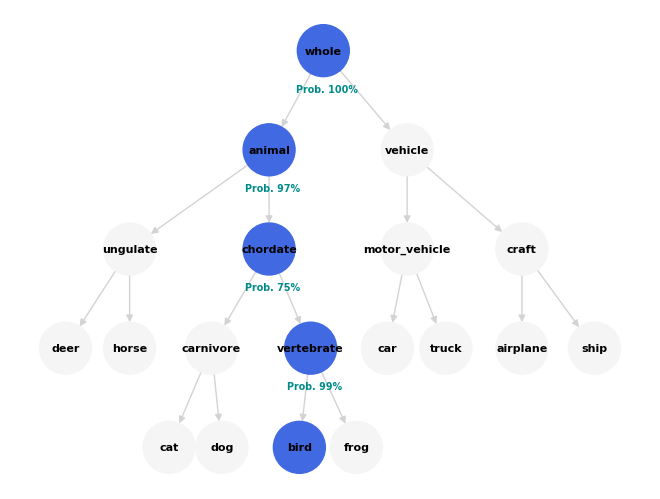

In [14]:
# visualize decisions
img_torch = (torch.tensor(img).movedim(-1, 0) / 255).unsqueeze(0).to(device)
plot_decision_tree(model_nbdt.forward_with_decisions(img_torch)[1][0], model_nbdt)